In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using {} device".format(device))

using cuda device


In [14]:
import torch
import os
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using {} device".format(device))

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

using cuda device
Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [15]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols , channels)

z_dim = 100

In [16]:
def build_generator(z_dim): # 생성자 정의
    
    model = Sequential()
    
    model.add(Dense(256* 7 *7 , input_dim = z_dim))
    model.add(Reshape((7, 7 , 256)))
    
    model.add(Conv2DTranspose(128 , kernel_size = 3, strides = 2 , padding = 'same'))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha = 0.01))
    
    model.add(Conv2DTranspose(64 , kernel_size = 3, strides =1 , padding = 'same'))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha = 0.01))
    
    model.add(Conv2DTranspose(1, kernel_size = 3, strides =2, padding = 'same'))
    
    model.add(Activation('tanh'))
    
    return model

In [17]:
def build_discriminator(img_shape):
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = img_shape, padding = 'same'))
    
    
    model.add(LeakyReLU(alpha = 0.01))
    
    model.add(Conv2D(64 , kernel_size = 3 , strides = 2, padding = 'same'))
    
    model.add(LeakyReLU(alpha = 0.01))
    
    model.add(Conv2D(128, kernel_size = 3, strides = 2 , padding = 'same'))
    
    model.add(LeakyReLU(alpha = 0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [18]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy' ,
                      optimizer = Adam(),
                      metrics = ['accuracy'])

generator = build_generator(z_dim)


gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy' , optimizer = Adam())

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations , batch_size , sample_interval):
    
    (X_train,_ ), ( Y_train , _) = np.load('./img_data2.npy',allow_pickle=True) 


    X_train = X_train / 127.5 -1.0
    X_train = np.expand_dims(X_train , axis = 3)
    
    real = np.ones((batch_size , 1))
    
    fake = np.zeros((batch_size , 1))
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        z = np.random.normal(0,1, (batch_size , 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs , real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs,fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real , d_loss_fake)
        
        z = np.random.normal(0,1, (batch_size , 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z , real)
        
        if (iteration + 1) % sample_interval ==0:
            
            losses.append((d_loss, g_loss))
            accuracies.append(100.0*accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [ D 손실 : %f, 정확도: %.2f%%] [ G손실 : %f]" % (iteration + 1 , d_loss , 100.0*accuracy , g_loss))
            
            sample_images(generator)
            
            

In [19]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

In [20]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [21]:
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         1637121   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 94721     
Total params: 1,731,842
Trainable params: 1,731,458
Non-trainable params: 384
_________________________________________________________________


In [22]:
def sample_images(generator, image_grid_rows = 4 , image_grid_columns = 4):
    z = np.random.normal(0,1, (image_grid_rows * image_grid_columns , z_dim))
    
    gen_imgs = generator.predict(z)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig , axs = plt.subplots(image_grid_rows , image_grid_columns, figsize = (4,4) , sharey = True , sharex = True)
    
    cnt = 0
    
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt , : , :, 0], cmap = 'gray')
            axs[i ,j].axis('off')
            cnt +=1
            
    plt.show()

100 [ D 손실 : 0.045101, 정확도: 100.00%] [ G손실 : 5.906718]


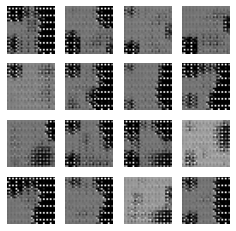

200 [ D 손실 : 0.000529, 정확도: 100.00%] [ G손실 : 7.809246]


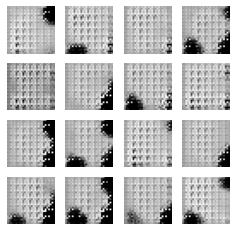

300 [ D 손실 : 0.007293, 정확도: 100.00%] [ G손실 : 0.010212]


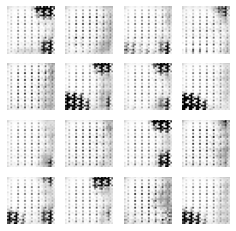

400 [ D 손실 : 0.023777, 정확도: 98.44%] [ G손실 : 31.049698]


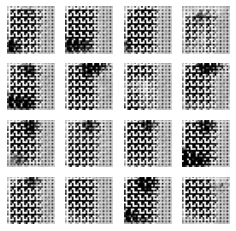

500 [ D 손실 : 0.001175, 정확도: 100.00%] [ G손실 : 0.003748]


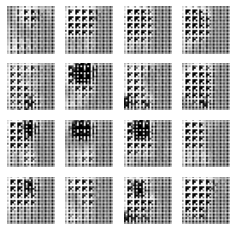

600 [ D 손실 : 1.105073, 정확도: 90.62%] [ G손실 : 0.014486]


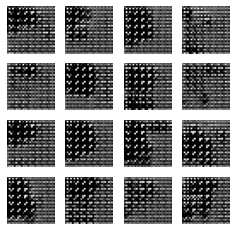

700 [ D 손실 : 0.000701, 정확도: 100.00%] [ G손실 : 0.256843]


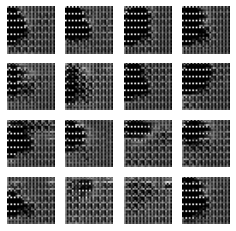

800 [ D 손실 : 10.164854, 정확도: 50.00%] [ G손실 : 94.097855]


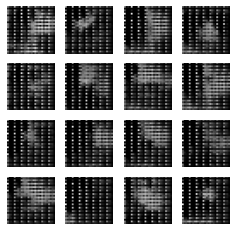

900 [ D 손실 : 0.000000, 정확도: 100.00%] [ G손실 : 109.816238]


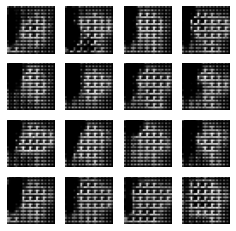

1000 [ D 손실 : 1.568428, 정확도: 85.94%] [ G손실 : 185.984177]


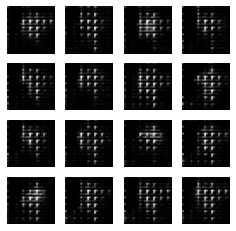

1100 [ D 손실 : 22.665745, 정확도: 50.00%] [ G손실 : 62.388283]


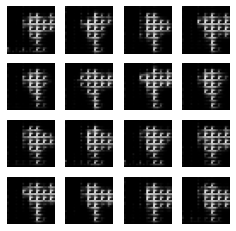

1200 [ D 손실 : 7.596605, 정확도: 49.22%] [ G손실 : 116.706894]


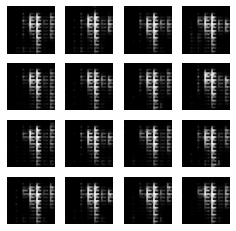

1300 [ D 손실 : 0.405829, 정확도: 96.88%] [ G손실 : 113.756912]


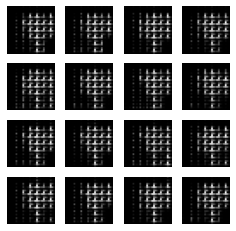

1400 [ D 손실 : 2.211754, 정확도: 46.88%] [ G손실 : 73.284149]


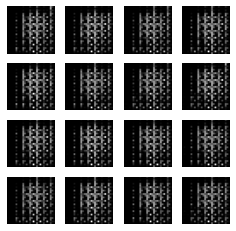

1500 [ D 손실 : 0.000000, 정확도: 100.00%] [ G손실 : 170.693451]


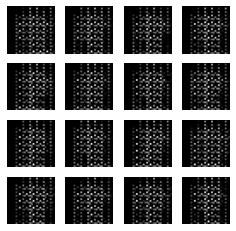

1600 [ D 손실 : 0.211053, 정확도: 98.44%] [ G손실 : 182.092316]


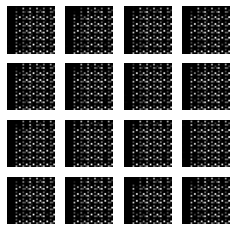

1700 [ D 손실 : 52.484021, 정확도: 55.47%] [ G손실 : 27.170071]


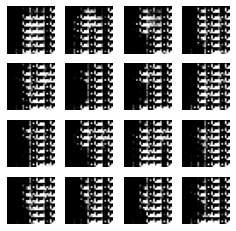

1800 [ D 손실 : 1.272400, 정확도: 89.84%] [ G손실 : 7.805022]


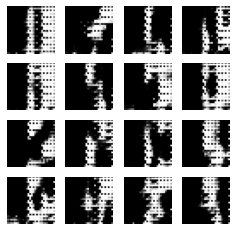

1900 [ D 손실 : 8.286105, 정확도: 68.75%] [ G손실 : 152.185226]


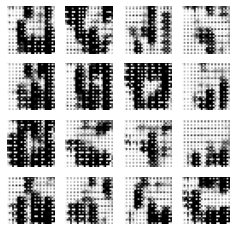

2000 [ D 손실 : 0.990768, 정확도: 96.09%] [ G손실 : 0.123823]


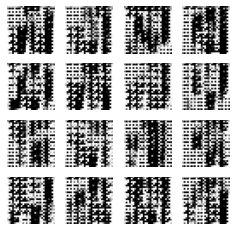

2100 [ D 손실 : 0.068029, 정확도: 97.66%] [ G손실 : 0.857172]


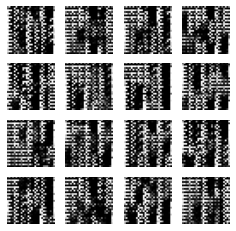

2200 [ D 손실 : 0.116135, 정확도: 96.88%] [ G손실 : 0.827988]


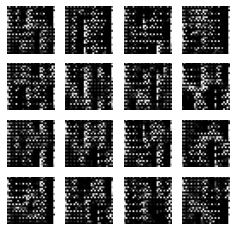

2300 [ D 손실 : 25.892559, 정확도: 50.00%] [ G손실 : 100.427101]


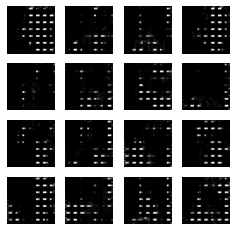

2400 [ D 손실 : 4.323650, 정확도: 68.75%] [ G손실 : 62.240517]


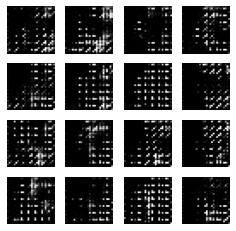

2500 [ D 손실 : 6.215298, 정확도: 55.47%] [ G손실 : 47.474228]


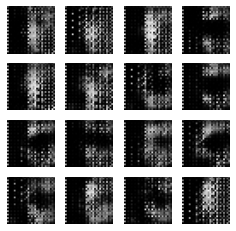

2600 [ D 손실 : 4.667832, 정확도: 60.16%] [ G손실 : 70.405029]


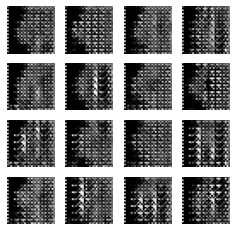

2700 [ D 손실 : 1.491962, 정확도: 89.06%] [ G손실 : 102.085342]


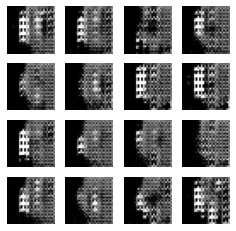

2800 [ D 손실 : 1.808256, 정확도: 76.56%] [ G손실 : 108.518433]


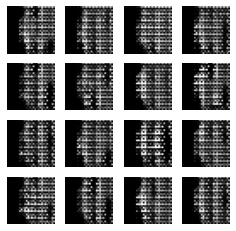

2900 [ D 손실 : 18.615519, 정확도: 46.09%] [ G손실 : 122.403595]


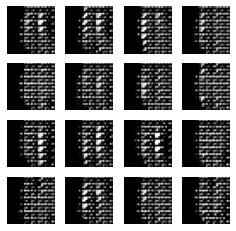

3000 [ D 손실 : 0.098332, 정확도: 99.22%] [ G손실 : 295.631012]


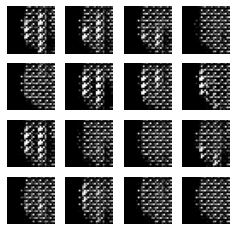

3100 [ D 손실 : 8.736950, 정확도: 61.72%] [ G손실 : 356.388733]


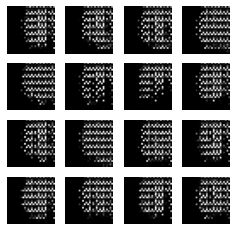

3200 [ D 손실 : 1.738281, 정확도: 95.31%] [ G손실 : 308.311951]


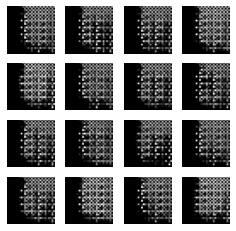

3300 [ D 손실 : 50.251122, 정확도: 50.00%] [ G손실 : 312.141724]


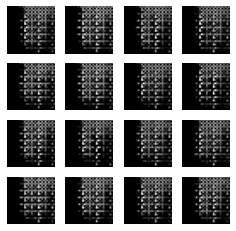

KeyboardInterrupt: 

In [23]:
iterations = 20000
batch_size = 64
sample_interval = 100
train(iterations , batch_size , sample_interval).to(device)

In [124]:
generator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 12544)             1266944   
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 64)      

In [150]:
z = np.random.normal(0,1, (batch_size , 100))
gen_imgs = generator.predict(z)
gen_imgs = (0.5* gen_imgs + 0.5) * 255

fin_img = np.resize(gen_imgs ,( 28 , 28))
print(fin_img)

[[2.37844443e+00 2.38095224e-02 5.92768192e-04 1.61035359e-02
  3.15119362e+00 8.35955143e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00